<a href="https://www.kaggle.com/code/mikekertser/titanic-notebook?scriptVersionId=101903317" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plots
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
def normality(x,alpha = 1e-3) -> bool:
    """
    This is a normality test, comparing p-value to alpha
    """
    k2, p = stats.normaltest(x.dropna().to_numpy())
    #print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        #The null hypothesis can be rejected - it seems to be normal
        return True
    else:
        #The null hypothesis cannot be rejected - it is non-normally distributed
        return False

In [3]:
# Load the dataset to dataframes
dstrain = pd.read_csv('../input/titanic/train.csv')
dstest = pd.read_csv('../input/titanic/test.csv')

In [4]:
# Let's take a look at the feaures of the training dataset
dstrain.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:
dstrain.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

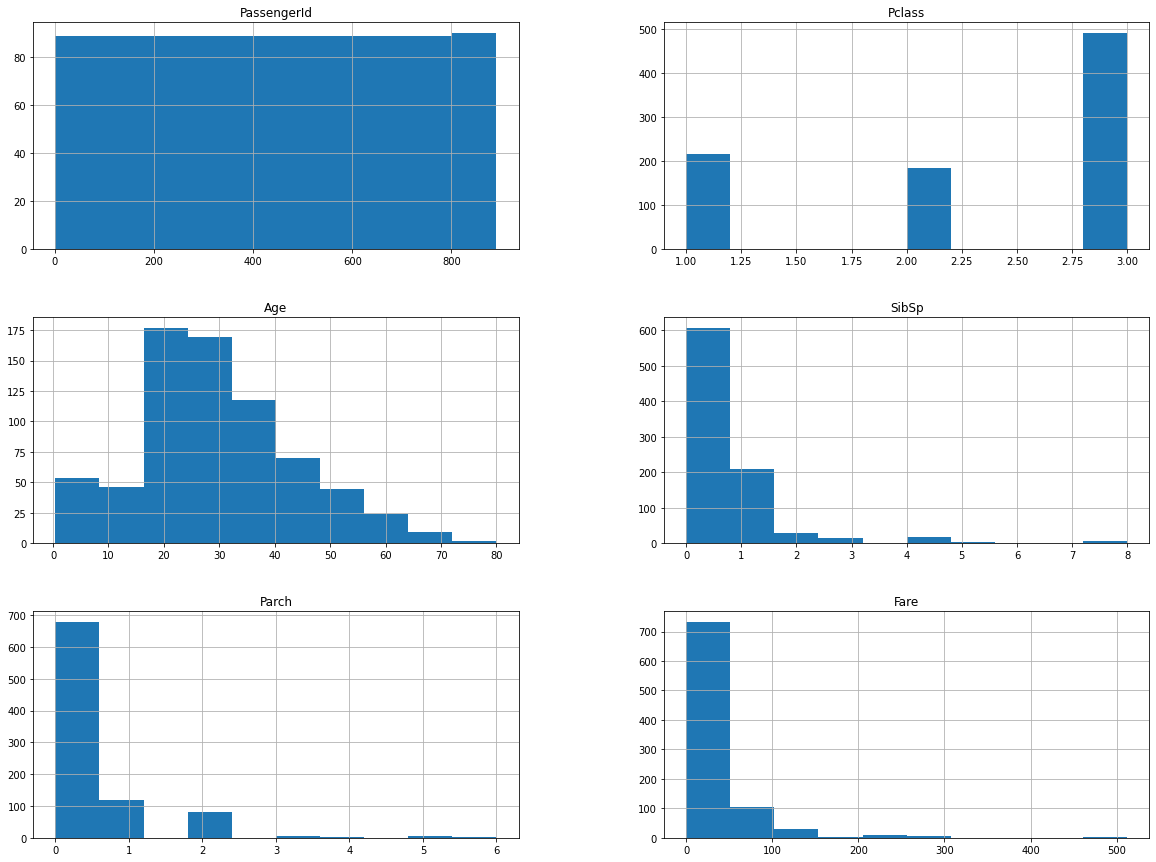

In [6]:
# Let's take a look at every numerical feature
dstrain.drop(['Survived'],axis=1).hist(figsize=(20, 15));

**__Data Encoding:__**

survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

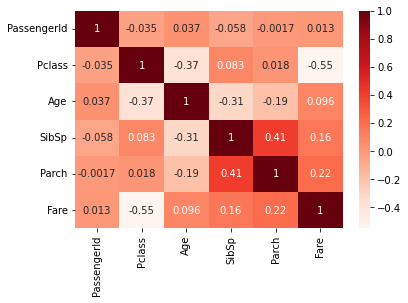

In [7]:
#Let's inspect the correlation matrix of features in terms of Pearson correlation heatmap
import seaborn as sns
correlation_mat = dstrain.drop(['Survived'],axis=1).iloc[:].corr()
sns.heatmap(correlation_mat, annot = True, cmap=plt.cm.Reds);

In [8]:
#Correlation with the target variable in general is relatively weak and mostly related to the Pclass and Fare
cor_target = dstrain.corr()
#sns.heatmap(cor_target, annot=True, cmap=plt.cm.Reds)
#plt.show()
cor_target = abs(cor_target["Survived"])
cor_target[cor_target>0.2]

Survived    1.000000
Pclass      0.338481
Fare        0.257307
Name: Survived, dtype: float64

Pclass is more strongly correlated with the target

- Pclass and Fare are negatively corellated with above 0.5 coeff. May be it worth to build a common feature out of both of them
- Age is weakly negatively correlated to Pclass and SibSp (number of siblings), but not to the Fare
- SibSp (sibling ans sposes) is positively correlated to Parch (parents and children) which is logical and once again may be used to construct a common feature.

In [9]:
normality(dstrain['Age'])

True

In [10]:
# 3 Classes, non-evenly distributed
dstrain.groupby("Pclass")["Pclass"].count()

Pclass
1    216
2    184
3    491
Name: Pclass, dtype: int64

In [11]:
# Let's see how many passengers had a zero Fare value:
sum(dstrain['Fare'] == 0)

15

In [12]:
#Box-Cox transform the Fare to remove the skewness (if it is positive, so OK)

crim_boxcox = stats.boxcox(dstrain[dstrain['Fare'] != 0]['Fare'])[0]
pd.Series(crim_boxcox).skew()

0.2178388994833782

* Age is equally distributed. Need to be normalized for models, affected by non-normalized features
* Fare is numerical value, but is skewed right.
- Unteresting point. 15 out of training dataset passangers had a free fare ticket. They might be a crew members or just an error. I would set their fare to some special value (like 0.1) and than perform the box-cox transform
* Pclass has only 3 values. 1-hot encoding seems to be an option.
* Names are worthless and shall be dropped.
* Sex shall be changed to [0,1] values - Male = 1, Female = 0
* Cabin has many NaNs and inadequate data. Need to be dropped or specially treated. Some hidden information may be there.
- The number of cabin consists of a letter (probably indicating a deck) and the number. NaNs are probably for the people that have traveled without the cabin.
- Let's reformat the data in such a way, that the Cabin deck will be extracted as A=1,B=2,etc and NaN=0, while the numbers of rooms will be dropped.
* Ticket number is worhtless as well - drop it
* Passenger ID - drop it, evely distributed, uncorrelated and probably has no effect on any result
* "Embarked" feature might have some correlation with the Fare. May be unified by it or just one-hot encode it
* Lasso reularization might be used on the set of features (despite the fact the number of features is relatively small and might be evaluated manually)

In [13]:
#List of all decks:
set(dstrain['Cabin'].str[0].tolist())

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan}

In [14]:
def feature_constructor(df):
    """
    This function will remove the unnecessary features, encode the parametric values and construct the rest
    """
    #Age - 177 NaNs in the training set. It is too much to drop. I'd take an average or median age
    df['Age'] = df['Age'].fillna(df['Age'].median())

    # Embarked - convert to numeric value
    df = df.join(pd.get_dummies(df['Embarked'],prefix='EmbarkedIn', prefix_sep='_'))
    df = df.drop('Embarked',axis = 1)
    
    medianF = df['Fare'].median()
    # Fare - replace the 0 with median fare and apply Box-Cox transform
    #df['Fare'].replace(to_replace = 0,value = medianF, inplace=True)
    
    # Fare - replace the 0 with 0.1 Fare and apply Box-Cox transform
    df['Fare'].replace(to_replace = 0,value = 0.1, inplace=True)

    # Constuct feature for Pclass/Fare (can cause a loss of information?)
    df['Fare_per_class'] = df['Fare']/df['Pclass']
    df['Fare_per_class'] = stats.boxcox(df['Fare_per_class'])[0]
    df = df.drop('Fare',axis = 1)
    
    # Extract the Decks from Cabin numebers and one-hot encode them. Drop the Cabin
    df['Deck'] = df['Cabin'].astype(str).str.upper().str[0]
    #df.loc[df["Deck"] == "A", "Deck"] = 1
    df = df.join(pd.get_dummies(df['Deck']))
    df = df.drop('Deck',axis = 1)
    df = df.drop('Cabin',axis = 1)
    try:
        df = df.drop('T',axis = 1) # This is a misstake value, not needed.
    except:
        pass #Non-existing feature

    # Dropping 'PassengerId','Name','Ticket'
    df = df.drop(['PassengerId','Name','Ticket'],axis=1)
    
    # Applying one-hot encoding for 'Sex' ["Female,Male"] -> [0,1]
    df = df.join(pd.get_dummies(df['Sex']))
    df = df.drop('Sex',axis = 1)
    
    # Remove the remaining NaNs, just in case
    pass

    return df

In [15]:
# Construct features and targets for Train and Validation datasets and split them accordingly
from sklearn.model_selection import train_test_split

y = dstrain['Survived']
X = feature_constructor(dstrain).drop('Survived',axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

We will try: 
- Decision Tree classifier
- RandomForestClassifier
- AdaBoostClassifier
- GradientBoostingClassifier
- XGBClassifier with k-fold cross-validation

Accuracy will be used as The Metrics

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold

In [17]:
#Decision Tree Classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
decision_tree_accuracy = accuracy_score(y_val, y_pred)

In [18]:
#Randoom Forest Classifier
clf = RandomForestClassifier(n_estimators=50, max_features="auto",random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
random_forest_accuracy = accuracy_score(y_val, y_pred)

In [19]:
#Ada Boost Classifier
clf = AdaBoostClassifier(n_estimators=50)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
adaboost_accuracy = accuracy_score(y_val, y_pred)

In [20]:
# Gradient Boosting Classifier
clf = GradientBoostingClassifier(n_estimators=50)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
gradient_boosting_accuracy = accuracy_score(y_val, y_pred)

In [21]:
# XGB Classifier
xgbc = XGBClassifier(max_depth=2,n_estimators=150)
xgbc.fit(X_train, y_train)
scores = cross_val_score(xgbc, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
ypred = xgbc.predict(X_val)
print(confusion_matrix(y_val,y_pred))
XGB_accuracy = accuracy_score(y_val, y_pred)

Mean cross-validation score: 0.83
K-fold CV average score: 0.82
[[92 13]
 [22 52]]


In [22]:
print('Decision Tree Classifier = ', round(decision_tree_accuracy,4))
print('Randoom Forest Classifier = ', round(random_forest_accuracy,4))
print('Ada Boost Classifier = ', round(adaboost_accuracy,4))
print('Gradient Boosting Classifier Accuracy = ', round(gradient_boosting_accuracy,4))
print('XGB Classifier Accuracy = ', round(XGB_accuracy,4))

Decision Tree Classifier =  0.7654
Randoom Forest Classifier =  0.7933
Ada Boost Classifier =  0.8045
Gradient Boosting Classifier Accuracy =  0.8045
XGB Classifier Accuracy =  0.8045


XGB seems to be a good one. Let's fine-tune it's hyperparemeters

In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [24]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [25]:
model = XGBClassifier()

param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [1, 1.5, 2, 5, 10],
        'subsample': [1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 7],
        'n_estimators': [100],
        'alpha': [0.2, 0.5, 1],
        'lambda': [0.2, 0.5, 1],
        'num_parallel_tree' : [5]
        }

model, y_pred = algorithm_pipeline(X_train, X_val, y_train, y_val, model, 
                                 param_grid, cv=10)

Fitting 10 folds for each of 1215 candidates, totalling 12150 fits
[CV] END alpha=0.2, colsample_bytree=0.6, gamma=1, lambda=0.2, max_depth=4, min_child_weight=1, n_estimators=100, num_parallel_tree=5, subsample=1.0; total time=   0.6s
[CV] END alpha=0.2, colsample_bytree=0.6, gamma=1, lambda=0.2, max_depth=4, min_child_weight=1, n_estimators=100, num_parallel_tree=5, subsample=1.0; total time=   0.6s
[CV] END alpha=0.2, colsample_bytree=0.6, gamma=1, lambda=0.2, max_depth=4, min_child_weight=5, n_estimators=100, num_parallel_tree=5, subsample=1.0; total time=   0.6s
[CV] END alpha=0.2, colsample_bytree=0.6, gamma=1, lambda=0.2, max_depth=4, min_child_weight=5, n_estimators=100, num_parallel_tree=5, subsample=1.0; total time=   0.6s
[CV] END alpha=0.2, colsample_bytree=0.6, gamma=1, lambda=0.2, max_depth=4, min_child_weight=5, n_estimators=100, num_parallel_tree=5, subsample=1.0; total time=   0.6s
[CV] END alpha=0.2, colsample_bytree=0.6, gamma=1, lambda=0.2, max_depth=4, min_child_we

In [26]:
#Best XGB model is:
print(model.best_params_)

best_model = XGBClassifier()
best_model.set_params(**model.best_params_)
best_model.fit(X_train, y_train)
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(best_model, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
y_pred = best_model.predict(X_val)
print(confusion_matrix(y_val,y_pred))
best_model_accuracy = accuracy_score(y_val, y_pred)
print('Best Model Accuracy = ', round(best_model_accuracy,4))

{'alpha': 0.2, 'colsample_bytree': 0.8, 'gamma': 1.5, 'lambda': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'num_parallel_tree': 5, 'subsample': 1.0}
Mean cross-validation score: 0.84
K-fold CV average score: 0.83
[[92 13]
 [21 53]]
Best Model Accuracy =  0.8101


In [27]:
#Alternative Best Model
params = {
    'alpha': 0.1, 
    'colsample_bytree': 0.8, 
    'gamma': 1.4, 
    'lambda': 0.1, 
    'max_depth': 5, 
    'min_child_weight': 5, 
    'n_estimators': 1000, 
    'num_parallel_tree': 5, 
    'subsample': 1}
model1 = XGBClassifier()
model1.set_params(**params)
model1.fit(X_train, y_train)
#scores = cross_val_score(model1, X_train, y_train, cv=10)
y_pred = model1.predict(X_val)
print(confusion_matrix(y_val,y_pred))
accuracy_score(y_val, y_pred)

[[94 11]
 [17 57]]


0.8435754189944135

In [28]:
#Make a prediction with the best model on test data
X_test = feature_constructor(dstest)
y_pred = best_model.predict(X_test)

In [29]:
# Export the predicted results
pd.DataFrame(dstest['PassengerId']).join(pd.DataFrame({"Survived":y_pred})).to_csv('/kaggle/working/TitanicPredict.csv')